In [17]:
import os
from dotenv import load_dotenv
load_dotenv()
import pandas as pd
from openai import OpenAI
import ollama

openai_key = os.getenv("OPENAI_KEY")

In [24]:
prompt = """
TASK:
Identify who is the patient and who is the attending medical professional(s) in the scenario below.

INSTRUCTIONS:
1. Read the scenario carefully.
2. Identify the patient by their name and role.
3. Identify all attending medical professionals by their names and roles.
4. ONLY list all identified names in the specified format.
5. Do not use numbers or bullet points.
6. Names should be separated by commas.
7. Do not include any additional information or context or explanations.
8. Ensure the output is strictly formatted as specified below.
9. Do not include extra characters for formatting.

OUTPUT FORMAT:
[Think] You actually think about who all are involved and in what capacity. Think carefully who is the patient(s) and who is the **attending** medical professional(s). [/Think]


Patient: patient_name1, patient_name2, patient_name3
Medical Professional(s): attending_medical_professional_name1, attending_medical_professional_name2, attending_medical_professional_name3


SCENARIO:
"""

In [51]:
context = """
Dr Amanda Lewis brought her husband, Michael Lewis, to urgent care after he collapsed at home complaining of dizziness and vision loss. Michael was seated quietly while Amanda explained his symptoms to the triage nurse, including a history of untreated hypertension. Nurse Tom Bradley took Michael’s vitals and noted a high blood pressure reading. Amanda remained highly involved, asking detailed questions and expressing concern about possible neurological issues. Michael, who seemed disoriented, responded briefly when asked. Dr. Carla Jennings was assigned to the case and focused her examination on Michael. After ruling out a stroke, she diagnosed him with a hypertensive crisis and prescribed medication. Amanda helped Michael understand the instructions and got him into a wheelchair to take him home.
"""

In [52]:
def get_gpt_response(prompt, context):
    client = OpenAI(
    api_key=openai_key  
)
    response = client.chat.completions.create(
                    
                    messages=[
                    {"role": "system", "content": prompt},
                    {"role": "user", "content": context},
                    ],
                    temperature=0,
                    model="gpt-4.1", 
                    seed=48,
                    max_tokens=5000
                )

    return response.choices[0].message.content


In [53]:
def get_ollama_response(prompt, context, model="llama3.1:8b"):
    response = ollama.chat(
        model=model,
        messages=[
            {
                "role": "user",
                "content": f"{prompt}{context}"
            }
        ],
    )
    return response['message']['content']

       

In [ ]:
all_results = []
all_models = []
for i in range(50):
    model = "gpt-4.1"
    result = get_gpt_response(prompt, context)
    all_results.append(result)
    all_models.append(model)

    model = "gemma3:12b"
    result = get_ollama_response(prompt, context, model=model)
    all_results.append(result)
    all_models.append(model)

    model = "llama3.1:8b"
    result = get_ollama_response(prompt, context, model=model)
    all_results.append(result)
    all_models.append(model)

    d = {
        "model": all_models,
        "result": all_results
    }

    df = pd.DataFrame(d)
    df.to_csv("prompting_results.csv", index=False, encoding='utf-8-sig')


In [87]:
df = pd.read_csv("prompting_results.csv")

## Evaluation

In [88]:
gt_patient = "Michael Lewis"
gt_medi_prof_1 = "Tom Bradley"
gt_medi_prof_2 = "Carla Jennings"
gt_family_member = "Amanda Lewis"

In [89]:
identified_patient = []
identified_medi_profs = []

for i in range(len(df)):
    model = df.iloc[i]["model"]
    response = df.iloc[i]["result"]
    gen_patient = response.split("Patient:")[1].split("\n")[0].strip()
    gen_medi_profs= response.split("Patient:")[1].split("\n")[1].split(":")[1].strip()

    if gt_patient.lower() in gen_patient.lower():
        identified_patient.append(1)
    else:
        identified_patient.append(0)

    if (gt_medi_prof_1.lower() in gen_medi_profs.lower()) and (gt_medi_prof_2.lower() in gen_medi_profs.lower()) and (gt_family_member.lower() not in gen_medi_profs.lower()):
        identified_medi_profs.append(1)
    else:
        identified_medi_profs.append(0)
    
    print(f"{i+1}. Model: {model}")
    print(f"Identified Patient: {gen_patient}")
    print(f"Identified Medical Professionals: {gen_medi_profs}")
    print()


1. Model: gpt-4.1
Identified Patient: Michael Lewis
Identified Medical Professionals: Tom Bradley, Carla Jennings

2. Model: gemma3:12b
Identified Patient: Michael Lewis
Identified Medical Professionals: Amanda Lewis, Tom Bradley, Carla Jennings

3. Model: llama3.1:8b
Identified Patient: Michael Lewis
Identified Medical Professionals: Dr. Carla Jennings, Nurse Tom Bradley, Dr. Amanda Lewis

4. Model: gpt-4.1
Identified Patient: Michael Lewis
Identified Medical Professionals: Tom Bradley, Carla Jennings

5. Model: gemma3:12b
Identified Patient: Michael Lewis
Identified Medical Professionals: Nurse Tom Bradley, Dr Carla Jennings

6. Model: llama3.1:8b
Identified Patient: Michael Lewis
Identified Medical Professionals: Dr. Carla Jennings, Nurse Tom Bradley, Dr. Amanda Lewis

7. Model: gpt-4.1
Identified Patient: Michael Lewis
Identified Medical Professionals: Tom Bradley, Carla Jennings

8. Model: gemma3:12b
Identified Patient: Michael Lewis
Identified Medical Professionals: Amanda Lewis,

In [90]:
df["correct_patient"] = identified_patient
df["correct_medi_profs"] = identified_medi_profs

df.to_csv("llm_prompt_comparison_results-identified.csv", index=False, encoding="utf-8-sig")

In [91]:
df_grouped = df.groupby("model").sum().reset_index()
df_grouped["correct_patient_percentage"] = df_grouped["correct_patient"] / 50 * 100
df_grouped["correct_medi_profs_percentage"] = df_grouped["correct_medi_profs"] / 50 * 100
df_grouped.sort_values(by="model", ascending=True, inplace=True)

In [92]:
df_grouped

,model,result,correct_patient,correct_medi_profs,correct_patient_percentage,correct_medi_profs_percentage
0,gemma3:12b,[Think] I need to carefully identify who is th...,50,21,100.0,42.0
1,gpt-4.1,[Think] Michael Lewis is the individual experi...,50,50,100.0,100.0
2,llama3.1:8b,Patient: Michael Lewis\nMedical Professional(s...,50,8,100.0,16.0


In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

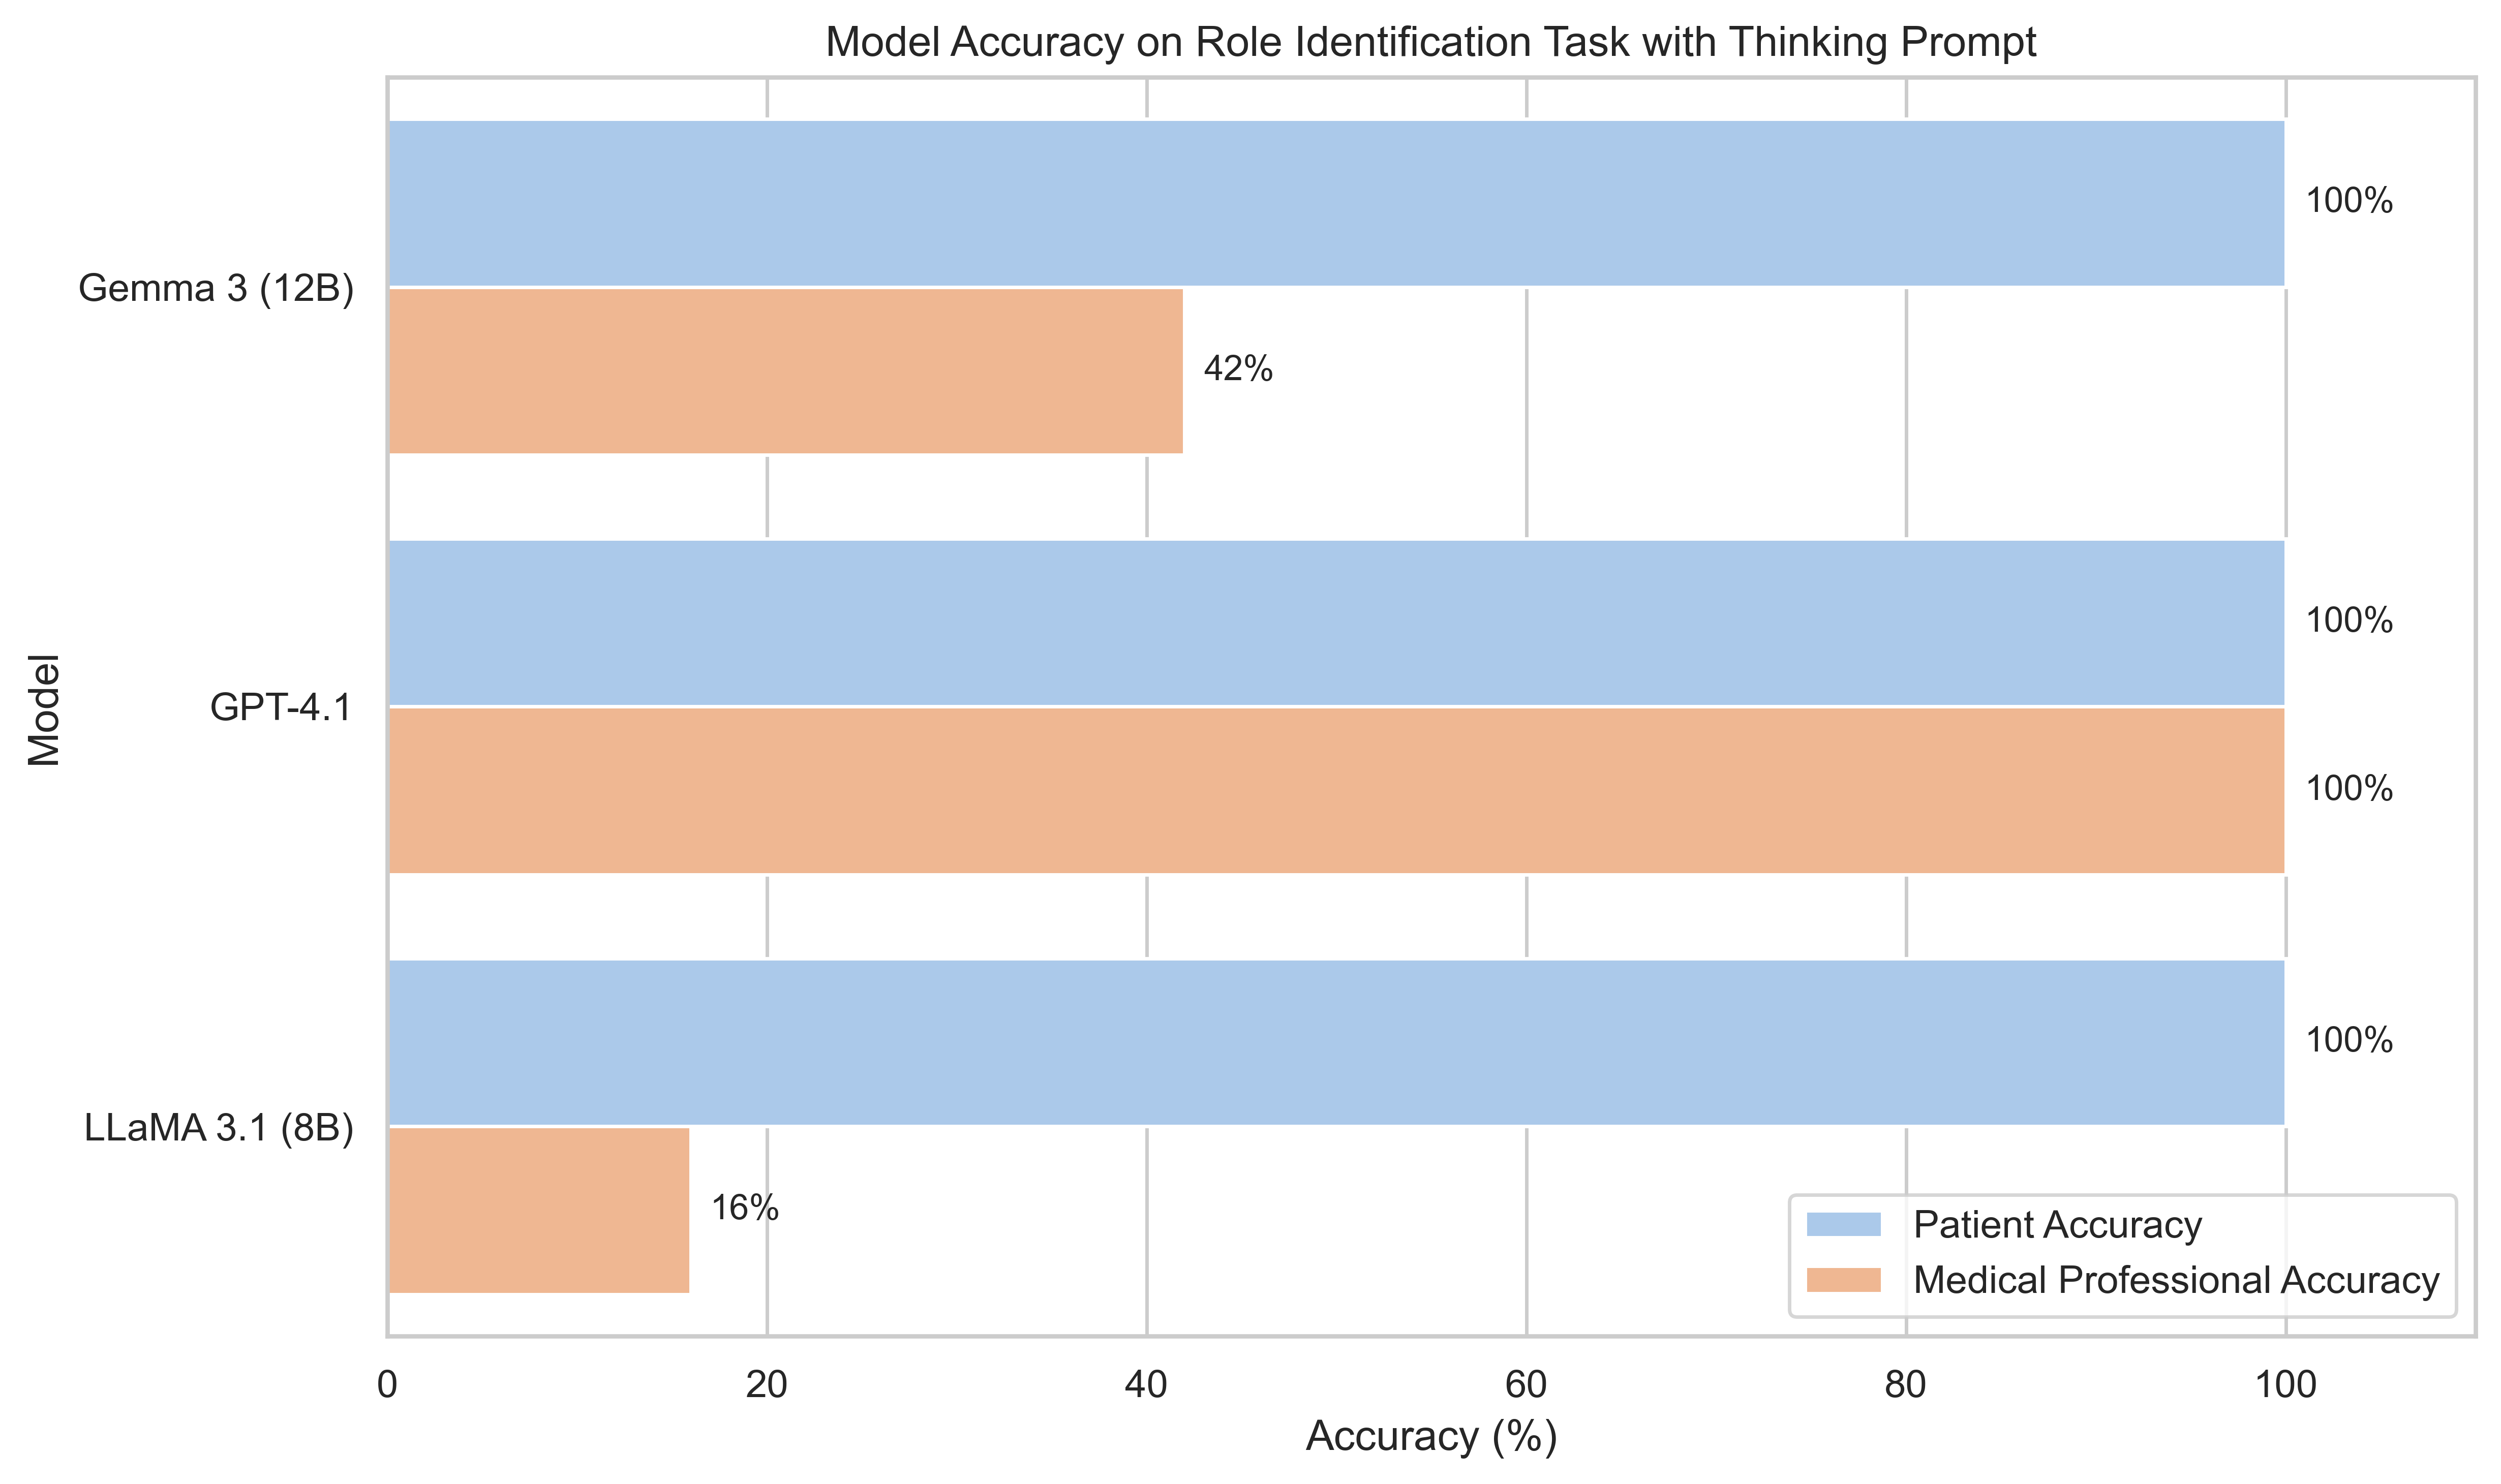

In [94]:
model_name_map = {
    'claude-opus-4-20250514': 'Claude Opus 4',
    'gemini2.5-flash': 'Gemini 2.5 Flash',
    'gemma3:12b': 'Gemma 3 (12B)',
    'gpt-4.1': 'GPT-4.1',
    'llama3.1:8b': 'LLaMA 3.1 (8B)'
}

df_grouped['model_clean'] = df_grouped['model'].map(model_name_map)

# print(df_grouped)
df_melted = df_grouped.melt(
    id_vars='model_clean',
    value_vars=['correct_patient_percentage', 'correct_medi_profs_percentage'],
    var_name='Metric',
    value_name='Accuracy'
)


df_melted['Metric'] = df_melted['Metric'].replace({
    'correct_patient_percentage': 'Patient Accuracy',
    'correct_medi_profs_percentage': 'Medical Professional Accuracy'
})


sns.set(style='whitegrid')
plt.figure(figsize=(10, 6), dpi=500)
ax = sns.barplot(
    x='Accuracy',
    y='model_clean',
    hue='Metric',
    data=df_melted,
    palette='pastel'
)


for container in ax.containers:
    for bar in container:
        width = bar.get_width()
        y = bar.get_y() + bar.get_height() / 2
        ax.text(
            width + 1,
            y,
            f'{width:.0f}%',
            va='center',
            ha='left',
            fontsize=10
        )

plt.title('Model Accuracy on Role Identification Task with Thinking Prompt')
plt.xlabel('Accuracy (%)')
plt.ylabel('Model')
plt.xlim(0, 110)
plt.legend(title='')
plt.tight_layout()
plt.show()
